# 9장. 텍스트를 분류합니다.

In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb

In [2]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

In [3]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [4]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [5]:
word_to_index = imdb.get_word_index()

word_to_index['movie']

17

In [6]:
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w - 3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [7]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [8]:
print(len(x_train_all[0]), len(x_train_all[1]))

59 32


In [9]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [10]:
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [11]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [12]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


In [13]:
print(x_train_seq[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


In [14]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [15]:
print(x_train_onehot.shape)

(20000, 100, 100)


In [16]:
print(x_train_onehot.nbytes)

800000000


In [17]:
import tensorflow as tf

In [18]:
class RecurrentNetwork:
    
    def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
        self.n_cells = n_cells     # 셀 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1h = None            # 은닉 상태에 대한 가중치
        self.w1x = None            # 입력에 대한 가중치
        self.b1 = None             # 순환층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.h = None              # 순환층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률

    def forpass(self, x):
        self.h = [np.zeros((x.shape[0], self.n_cells))]   # 은닉 상태를 초기화합니다.
        # 배치 차원과 타임 스텝 차원을 바꿉니다.
        seq = np.swapaxes(x, 0, 1)
        # 순환 층의 선형 식을 계산합니다.
        for x in seq:
            z1 = np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
            h = np.tanh(z1)                    # 활성화 함수를 적용합니다.
            self.h.append(h)                   # 역전파를 위해 은닉 상태 저장합니다.
            z2 = np.dot(h, self.w2) + self.b2  # 출력층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.h[-1].T, err) / m
        b2_grad = np.sum(err) / m
        # 배치 차원과 타임 스텝 차원을 바꿉니다.
        seq = np.swapaxes(x, 0, 1)
        
        w1h_grad = w1x_grad = b1_grad = 0
        # 셀 직전까지 그래디언트를 계산합니다.
        err_to_cell = np.dot(err, self.w2.T) * (1 - self.h[-1] ** 2)
        # 모든 타임 스텝을 거슬러가면서 그래디언트를 전파합니다.
        for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
            w1h_grad += np.dot(h.T, err_to_cell)
            w1x_grad += np.dot(x.T, err_to_cell)
            b1_grad += np.sum(err_to_cell, axis=0)
            # 이전 타임 스텝의 셀 직전까지 그래디언트를 계산합니다.
            err_to_cell = np.dot(err_to_cell, self.w1h) * (1 - h ** 2)
        
        w1h_grad /= m
        w1x_grad /= m
        b1_grad /= m
    
        return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def init_weights(self, n_features, n_classes):
        orth_init = tf.initializers.Orthogonal()
        glorot_init = tf.initializers.GlorotUniform()
        
        self.w1h = orth_init((self.n_cells, self.n_cells)).numpy() # (셀 개수, 셀 개수)
        self.w1x = glorot_init((n_features, self.n_cells)).numpy() # (특성 개수, 셀 개수)
        self.b1 = np.zeros(self.n_cells)                           # 은닉층의 크기
        self.w2 = glorot_init((self.n_cells, n_classes)).numpy()   # (셀 개수, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        np.random.seed(42)
        self.init_weights(x.shape[2], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                a = self.training(x_batch, y_batch) ## 7장 training 메서드에 x_val, y_val 지우기
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss = np.mean(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
                batch_losses.append(loss)
            print()
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y): ## 7장 training 메서드에 x_val, y_val 지우기
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.sigmoid(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 셀의 가중치와 절편을 업데이트합니다.
        self.w1h -= self.lr * w1h_grad
        self.w1x -= self.lr * w1x_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return z > 0                 # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.sigmoid(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        val_loss = np.mean(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append(val_loss)

In [19]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)

rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

에포크 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 ..........................................................................................................................................................................................................................................................................................................................................................................

에포크 12 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 13 ........................................................................................................................................................................................................................................................................................................................................................................

In [20]:
import matplotlib.pyplot as plt

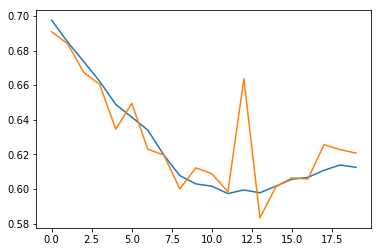

In [21]:
plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.savefig('gen_images/09_writer_001.png', dpi=300)
plt.show()

In [22]:
rn.score(x_val_onehot, y_val)

0.6572

## SimpleRNN

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [24]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(100, 100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, 
                    validation_data=(x_val_onehot, y_val))

W0818 17:37:13.085014 139708119009088 deprecation.py:323] From /home/haesun/anaconda3/envs/do-it-dl/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.6982 - accuracy: 0.5171 - val_loss: 0.6939 - val_accuracy: 0.5298
Epoch 2/20
20000/20000 [==============================] - 21s 1ms/sample - loss: 0.6825 - accuracy: 0.5641 - val_loss: 0.6675 - val_accuracy: 0.6004
Epoch 3/20
20000/20000 [==============================] - 21s 1ms/sample - loss: 0.6643 - accuracy: 0.6008 - val_loss: 0.6523 - val_accuracy: 0.6222
Epoch 4/20
20000/20000 [==============================] - 21s 1ms/sample - loss: 0.6415 - accuracy: 0.6361 - val_loss: 0.6811 - val_accuracy: 0.5718
Epoch 5/20
20000/20000 [==============================] - 21s 1ms/sample - loss: 0.6253 - accuracy: 0.6558 - val_loss: 0.6066 - val_accuracy: 0.6796
Epoch 6/20
20000/20000 [==============================] - 21s 1ms/sample - loss: 0.6129 - accuracy: 0.6691 - val_loss: 0.5922 - val_accuracy: 0.6844
Epoch 7/20
20000/20000 [==============================] -

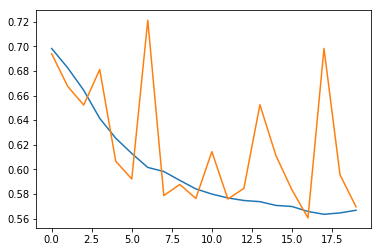

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.savefig('gen_images/09_writer_002.png', dpi=300)
plt.show()

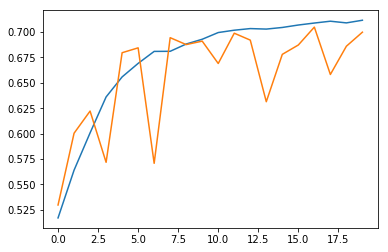

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.savefig('gen_images/09_writer_003.png', dpi=300)
plt.show()

In [27]:
model.evaluate(x_val_onehot, y_val)

5000/5000 [==============================] - 3s 547us/sample - loss: 0.5696 - accuracy: 0.6998


[0.5695908466339111, 0.6998]

## 단어 임베딩

In [30]:
from tensorflow.keras.layers import Embedding

In [43]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
    
x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [46]:
maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [117]:
model_ebd = Sequential()

model_ebd.add(Embedding(1000, 32))
model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))

model_ebd.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 8)                 328       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [119]:
model_ebd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_ebd.fit(x_train_seq, y_train, epochs=10, batch_size=32, 
                        validation_data=(x_val_seq, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 61s 3ms/sample - loss: 0.5619 - accuracy: 0.7131 - val_loss: 0.4802 - val_accuracy: 0.7838
Epoch 2/10
20000/20000 [==============================] - 61s 3ms/sample - loss: 0.4204 - accuracy: 0.8189 - val_loss: 0.4394 - val_accuracy: 0.8046
Epoch 3/10
20000/20000 [==============================] - 61s 3ms/sample - loss: 0.3755 - accuracy: 0.8413 - val_loss: 0.4264 - val_accuracy: 0.8110
Epoch 4/10
20000/20000 [==============================] - 61s 3ms/sample - loss: 0.3502 - accuracy: 0.8551 - val_loss: 0.4310 - val_accuracy: 0.8134
Epoch 5/10
20000/20000 [==============================] - 61s 3ms/sample - loss: 0.3190 - accuracy: 0.8694 - val_loss: 0.4223 - val_accuracy: 0.8248
Epoch 6/10
20000/20000 [==============================] - 61s 3ms/sample - loss: 0.2955 - accuracy: 0.8813 - val_loss: 0.4275 - val_accuracy: 0.8204
Epoch 7/10
20000/20000 [==============================] -

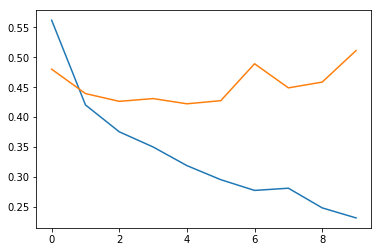

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.savefig('gen_images/09_writer_004.png', dpi=300)
plt.show()

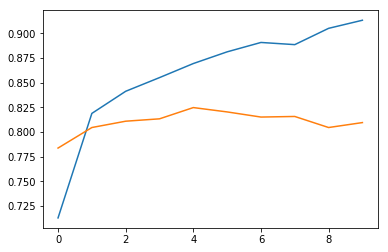

In [121]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.savefig('gen_images/09_writer_005.png', dpi=300)
plt.show()

In [122]:
model_ebd.evaluate(x_val_seq, y_val)

5000/5000 [==============================] - 2s 352us/sample - loss: 0.5112 - accuracy: 0.8096


[0.5112478697776794, 0.8096]

## LSTM

In [71]:
from tensorflow.keras.layers import LSTM

In [111]:
model_lstm = Sequential()

model_lstm.add(Embedding(1000, 32))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 8)           8000      
_________________________________________________________________
lstm_8 (LSTM)                (None, 1)                 40        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 2         
Total params: 8,042
Trainable params: 8,042
Non-trainable params: 0
_________________________________________________________________


In [113]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(x_train_seq, y_train, epochs=10, batch_size=32, 
                         validation_data=(x_val_seq, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 162us/sample - loss: 0.6315 - accuracy: 0.6907 - val_loss: 0.5494 - val_accuracy: 0.7886
Epoch 2/10
20000/20000 [==============================] - 3s 137us/sample - loss: 0.4917 - accuracy: 0.8173 - val_loss: 0.4798 - val_accuracy: 0.8044
Epoch 3/10
20000/20000 [==============================] - 3s 136us/sample - loss: 0.4312 - accuracy: 0.8332 - val_loss: 0.4470 - val_accuracy: 0.8146
Epoch 4/10
20000/20000 [==============================] - 3s 137us/sample - loss: 0.3953 - accuracy: 0.8479 - val_loss: 0.4288 - val_accuracy: 0.8196
Epoch 5/10
20000/20000 [==============================] - 3s 136us/sample - loss: 0.3732 - accuracy: 0.8544 - val_loss: 0.4195 - val_accuracy: 0.8260
Epoch 6/10
20000/20000 [==============================] - 3s 136us/sample - loss: 0.3569 - accuracy: 0.8622 - val_loss: 0.4218 - val_accuracy: 0.8234
Epoch 7/10
20000/20000 [===========================

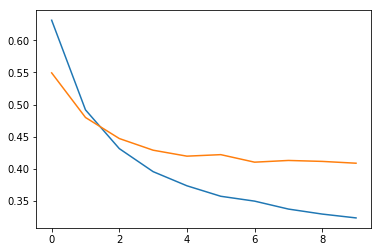

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.savefig('gen_images/09_writer_006.png', dpi=300)
plt.show()

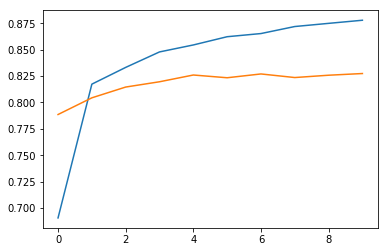

In [115]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.savefig('gen_images/09_writer_007.png', dpi=300)
plt.show()

In [116]:
model_lstm.evaluate(x_val_seq, y_val)

5000/5000 [==============================] - 0s 57us/sample - loss: 0.4085 - accuracy: 0.8274


[0.40847913064956665, 0.8274]